In [1]:
%matplotlib inline
%pylab inline
import pandas as pd
import numpy as np
import sys,os,re,csv,glob,collections,itertools,pickle,datetime
import dateutil
import igraph
import shapefile
import numpy.ma as ma
import matplotlib
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import gdal
import scipy.io
import matplotlib.image as mpimg

from scipy.spatial import ConvexHull
from sklearn.decomposition import FastICA as ICA
from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter as gaussfilter
from sklearn.neighbors import KDTree
from mapbox import Static
from tqdm import tqdm
from gdalconst import *
from scipy.misc import imresize
from scipy.misc import imsave
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from shapely.geometry import Point as SPoint
from shapely.geometry.polygon import Polygon as SPolygon
from statsmodels.tsa.stattools import grangercausalitytests as granger
figsize(16,16)

Populating the interactive namespace from numpy and matplotlib


### Minimum Bounding Rectangle

In [2]:
def mbr(points):

    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    #find rotation matrices
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((5, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)
    rval[4] = np.dot([x1, y2], r)

    return rval

### Calculate extent

In [3]:
def calculateExtent(geotransform,cols,rows):
     
    lonS = geotransform[0]
    latS = geotransform[3]
    lonE = lonS + cols*geotransform[1]
    latE = latS + rows*geotransform[5]
    return lonS,latS,lonE,latE

### Calculate X and Y position from lattitude and longitude

In [4]:
def transformLatLon2XY(extent,geotransform,cols,rows,lat,lon):
 
    xval = np.linspace(extent[0],extent[2],cols)
    yval = np.linspace(extent[1],extent[3],rows)
    xpix = np.argmin((xval-lon)**2)
    ypix = np.argmin((yval-lat)**2)
    return xpix,ypix

### Calculate lattitude and longitude from X and Y position

In [5]:
def transformXY2LatLon(extent,geotransform,cols,rows,xpix,ypix):

    xval = np.linspace(extent[0],extent[2],cols)
    yval = np.linspace(extent[1],extent[3],rows)
    return xval[xpix],yval[ypix]

### Load Contour Shapefile

In [6]:
sf = shapefile.Reader('../../data/spacenet/outline.shp')
cshapes = sf.shapes()
crecords = sf.records()
cfields = sf.fields

### Load Housing Shapefile

In [7]:
sf = shapefile.Reader('../../data/spacenet/houses.shp')
shapes = sf.shapes()
records = sf.records()
fields = sf.fields

### Find Centroids

In [8]:
info = []
C = []
A = []
for i in range(len(shapes)):
    maxarea = 0
    points = np.array(shapes[i].points)
    C.append((points[0][0],points[0][1]))
C = np.array(C)

### Plot Contour Shapefile

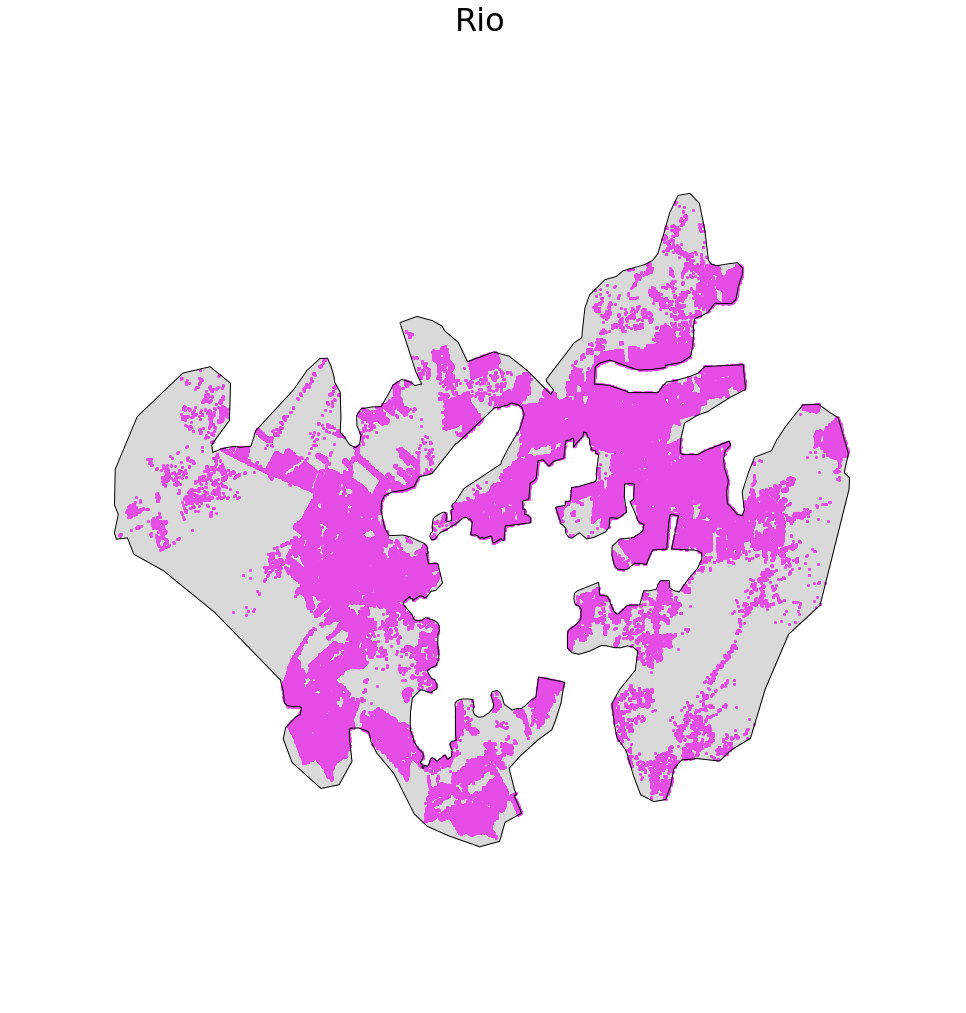

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
for nshp in xrange(len(cshapes)):
    ptchs = []
    pts = np.array(cshapes[nshp].points)
    prt = cshapes[nshp].parts
    par = list(prt) + [pts.shape[0]]
    ptchs.append(Polygon(pts))
    plt.plot(pts[:,0],pts[:,1],color='black')
    ax.add_collection(PatchCollection(ptchs,edgecolor='black',linewidths=0,color=(0.85,0.85,0.85),alpha=1.0))
plt.scatter(C[:,0],C[:,1],color=(0.9,0.3,0.9),s=10,edgecolor='black',linewidths=0.0)
plt.axis('off');
plt.suptitle('Rio',fontsize=32);

### Read Satellite Image Extents

In [10]:
dataset = gdal.Open('../../data/spacenet/srcData/mosaic_3band_reshaped2/combined.tif')
cols = dataset.RasterXSize
rows = dataset.RasterYSize
geotransform = dataset.GetGeoTransform()
extent = calculateExtent(geotransform,cols,rows)
band = dataset.GetRasterBand(1)
R = band.ReadAsArray(0, 0, cols, rows)
band = dataset.GetRasterBand(2)
G = band.ReadAsArray(0, 0, cols, rows)
band = dataset.GetRasterBand(3)
B = band.ReadAsArray(0, 0, cols, rows)

### Build KD Tree

In [11]:
tree = KDTree(C, leaf_size=2)           

In [12]:
def bbox2polygon(b):
    
    p = []
    p.append((b[0],b[1]))
    p.append((b[2],b[1]))
    p.append((b[2],b[3]))
    p.append((b[0],b[3]))
    p.append((b[0],b[1]))
    p = np.array(p)
    return p

In [54]:
def polygon2raster(M,I,myExtent,points,bounds):
    
    #Find the image coordinates of the bounding box
    xval = np.linspace(myExtent[0],myExtent[1],I.shape[0])
    yval = np.linspace(myExtent[3],myExtent[2],I.shape[0])

    shape = []
    for point in points:
        px = np.argmin((xval - point[0])**2)
        py = np.argmin((yval - point[1])**2)
        shape.append((px,py))
    shape = np.array(shape)
    poly = SPolygon(shape)

    #Find pixels for bounding box
    px1t = np.argmin((xval - bounds[0])**2)
    px2t = np.argmin((xval - bounds[2])**2)
    py1t = np.argmin((yval - bounds[1])**2)
    py2t = np.argmin((yval - bounds[3])**2)

    #Reverse for correct orientation
    if (px1t > px2t):
        px1 = px2t
        px2 = px1t
    else:
        px2 = px2t
        px1 = px1t

    #Reverse for correct orientation
    if (py1t > py2t):
        py1 = py2t
        py2 = py1t
    else:
        py2 = py2t
        py1 = py1t    
        
    for i in range(px1,px2):
        for j in range(py1,py2):
            if (poly.contains(SPoint(i,j)) == True):
                M[j,i] = 1

    #Return        
    return M

### Generate Training/Validation Images

In [69]:
#Pick Random Location
fov = 256
imCount = 5000
for curIm in tqdm(range(0,750)):

    verbose = 0
    randval = np.random.randint(C.shape[0])
    c = np.zeros((1,2))
    c[0,0] = C[randval,0]
    c[0,1] = C[randval,1]


    #Get Lon/Lat
    lon,lat = C[randval,:]


    #Get Center Pixel
    xpix,ypix = transformLatLon2XY(extent,geotransform,cols,rows,lat,lon)


    #Get Extend
    slon,slat = transformXY2LatLon(extent,geotransform,cols,rows,xpix-fov,ypix-fov)
    elon,elat = transformXY2LatLon(extent,geotransform,cols,rows,xpix+fov,ypix+fov)
    myExtent = (slon,elon,elat,slat)


    #Get Image
    I = np.zeros((fov*2,fov*2,3))
    I[:,:,0] = R[ypix-fov:ypix+fov,xpix-fov:xpix+fov]
    I[:,:,1] = G[ypix-fov:ypix+fov,xpix-fov:xpix+fov]
    I[:,:,2] = B[ypix-fov:ypix+fov,xpix-fov:xpix+fov]
    IC = I.copy()


    #Find all shapes within the extent
    dist,ind = tree.query(c,C.shape[0])


    #Get All Buildings fully within the image
    M = np.zeros((512,512))
    for i in range(1000):
        X = shapes[ind[0][i]].points
        bbox = shapes[ind[0][i]].bbox
        if (bbox[0] > myExtent[0] and bbox[2] < myExtent[1]):
            if (bbox[1] > myExtent[2] and bbox[3] < myExtent[3]):

                #Find bounding box and minimum spanning rectangle
                X = np.array(X)
                points = shapes[ind[0][i]].points
                bounds = shapes[ind[0][i]].bbox
                M = polygon2raster(M,I,myExtent,points,bounds)
               

    #Copy
    Ir = I[:,:,0]
    Ig = I[:,:,1]
    Ib = I[:,:,2]
    img1 = I
    img2 = np.zeros((I.shape))
    img3 = np.zeros((I.shape))
    img4 = np.zeros((I.shape))
    
    #Image 2
    img2[:,:,0] = np.fliplr(Ir)
    img2[:,:,1] = np.fliplr(Ig)
    img2[:,:,2] = np.fliplr(Ib)    

    #Image 3
    img3[:,:,0] = np.flipud(Ir)
    img3[:,:,1] = np.flipud(Ig)
    img3[:,:,2] = np.flipud(Ib)

    #Image 4
    img4[:,:,0] = np.transpose(Ir)
    img4[:,:,1] = np.transpose(Ig)
    img4[:,:,2] = np.transpose(Ib)

    #Masks
    mask1 = M
    mask2 = np.fliplr(M)
    mask3 = np.flipud(M)
    mask4 = np.transpose(M)
    
    #Save Image and Mask 1
    os.system('mkdir -p ../../data/spaceNet/segmentNet/raw/images/')
    filename = '../../data/spaceNet/segmentNet/raw/images/' + '/' + str(int(imCount)) + '.png'
    imsave(filename, img1)
    os.system('mkdir -p ../../data/spaceNet/segmentNet/raw/label/')
    filename = '../../data/spaceNet/segmentNet/raw/label/' + '/' + str(int(imCount)) + '.png'
    imsave(filename, mask1)
    imCount = imCount + 1

    #Save Image and Mask 1
    os.system('mkdir -p ../../data/spaceNet/segmentNet/raw/images/')
    filename = '../../data/spaceNet/segmentNet/raw/images/' + '/' + str(int(imCount)) + '.png'
    imsave(filename, img2)
    os.system('mkdir -p ../../data/spaceNet/segmentNet/raw/label/')
    filename = '../../data/spaceNet/segmentNet/raw/label/' + '/' + str(int(imCount)) + '.png'
    imsave(filename, mask2)
    imCount = imCount + 1
    
    #Save Image and Mask 1
    os.system('mkdir -p ../../data/spaceNet/segmentNet/raw/images/')
    filename = '../../data/spaceNet/segmentNet/raw/images/' + '/' + str(int(imCount)) + '.png'
    imsave(filename, img3)
    os.system('mkdir -p ../../data/spaceNet/segmentNet/raw/label/')
    filename = '../../data/spaceNet/segmentNet/raw/label/' + '/' + str(int(imCount)) + '.png'
    imsave(filename, mask3)
    imCount = imCount + 1
    
    #Save Image and Mask 1
    os.system('mkdir -p ../../data/spaceNet/segmentNet/raw/images/')
    filename = '../../data/spaceNet/segmentNet/raw/images/' + '/' + str(int(imCount)) + '.png'
    imsave(filename, img4)
    os.system('mkdir -p ../../data/spaceNet/segmentNet/raw/label/')
    filename = '../../data/spaceNet/segmentNet/raw/label/' + '/' + str(int(imCount)) + '.png'
    imsave(filename, mask4)
    imCount = imCount + 1
    
